# Classification with Logistic Regression

In today's exercise, we'll introduce **logistic regression** as a mechanism for performing _classification tasks_. This exercise walks through a conceptual example discussd in chapter 4 of [this book](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf), and the data was extracted from the `ISLR` R package (specifically, the `Default` dataset). The question of interest for this exercise is, 

> Can we predict which individuals will default on their credit card payments?


# Set Up (0 minutes)

In [8]:
# Set up
import numpy as np
from __future__ import division # division
import pandas as pd
import seaborn as sns # for visualiation
from scipy.stats import ttest_ind # t-tests
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt # plotting
import matplotlib
from sklearn import metrics
matplotlib.style.use('ggplot')
%matplotlib inline

# Load the data, replace strings as numeric
df = pd.read_csv('./data/payment-default.csv')
df.default = df.default.replace(['Yes', 'No'], [1, 0]).astype(int)
df.student = df.student.replace(['Yes', 'No'], [1, 0]).astype(int)

# Data Exploration (15 minutes)

In this first section, you'll explore your dataset to get a better handle on the distributions. The data for this exercise has **10,000** observations (people), who did, or did not, default on their credit card payment. The data has the following information for each person:

- `default`: This is our **outcome** of interest, and is **binary** (yes/no)
- `student`: This variable indicates if each person is a students (yes/no)
- `balance`: Current balance on the credit card (**continuous**)
- `income`: Annual income of the individual (**continuous**)

In this section, you'll write the code necessary to answer the following questions:

- What is the **default rate** in the dataset (# of defaults / total)
- What is the distribution of credit card **balances** (for those who default, and those who do not)?
- What is the relationship between `balance` and `income` (show a scatter-plot, different colors for default/no default)?


In [9]:
# What is the **default rate** in the dataset (# of defaults / total)
valueArray = df['default'].value_counts()
ratio = valueArray / df['default'].count()
print 'The default rate is', ratio[1]*100, '%'

The default rate is 3.33 %


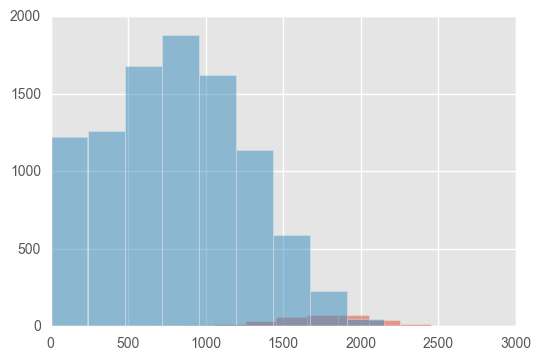

In [10]:
# What is the distribution of balances (for those who default, and those who don't)?
# You may want to create subsets of the data for those who defaulted, and those who did not
# Draw histograms of the distribution (perhaps overlapping histogram on the same chart)
default = df.loc[df['default'] == 1]
other = df.loc[df['default'] == 0]
default['balance'].hist(alpha=0.5, label='default')
other['balance'].hist(alpha=0.5, label='non_default')

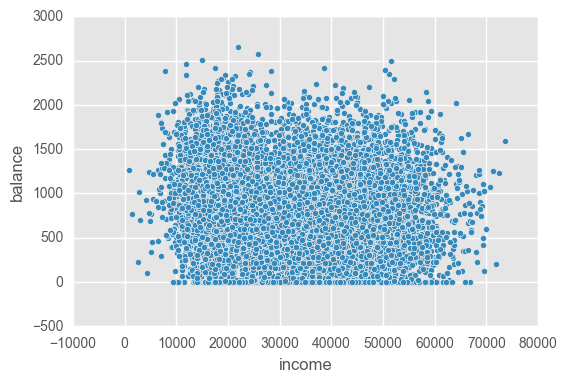

In [11]:
# What is the relationship between balalance and income (show a scatter-plot, different colors for default/no default)?
# Hint: http://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
df.plot(kind='scatter', x='income', y='balance')

List pertinent observations from the above analysis:

> Your insights here...

# A Linear Approach (15 minutes)

Before introducing a new estimation approach, we'll observe the limitations of using a linear estimation of a binary outcome. In this section, you'll do the following:

- Fit a **linear model** of the dependent variable (`default`) on _one_ indepdendent variable (`balance`)
- Generate predictions using your model (this can be interpreted as _probability of default_)
- Visualize the results (comparing `balance` to the predicted `default` rate)
- Interpret the **coefficients** and assess the **model fit**

In [12]:
# Fit a linear model of the dependent variable (default) on balance
results = smf.ols('default ~ balance', data=df).fit()

# Inspect the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1397.
Date:                Mon, 13 Feb 2017   Prob (F-statistic):          2.77e-286
Time:                        14:45:24   Log-Likelihood:                 3644.8
No. Observations:               10000   AIC:                            -7286.
Df Residuals:                    9998   BIC:                            -7271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0752      0.003    -22.416      0.000        -0.082    -0.069
balance        0.0001   3.47e-06     37.374      0.000         0.000     0.000
==============================================================================
Omnibus:                     8547.967   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           180810.806
Skew:                           4.243   Prob(JB):                         0.00
Kurtosis:                      22.025   Cond. No.                     1.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# Generate predictions using your model (this can be interpreted as probability of default)
df['predicted_ln'] = results.predict()

NameError: name 'ss' is not defined

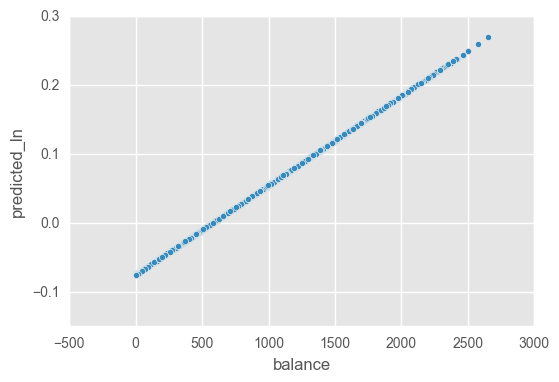

In [14]:
# Visualize the results: scatterplot of balance v.s. predcited default rate. Bonus: add actual default rate.
df.plot(kind='scatter', x='balance', y='predicted_ln')
ss.scatter(predicted_ln,)

In [15]:
# Interpret the **coefficients** and assess the **model fit**df


What is your interpretation of the coefficients and your assessment of the model fit?

> Your insights here

# The Logistic Function (10 minutes)

For this section, you'll simply familiarize yourself with the **Logistic Function**. In order to perform **classification**, we want to explicitly **model the probability** of falling into each category. Given the limitations of linear regression, we want to find a functional form with the following property:

> _All values output by the function should fall **between 0 and 1**._

Because we are modeling **conditional probability**, we will annotate our formula using the following shorthand:

\begin{equation*}
p(X)= Pr\left(Y=1|X\right) \\
\end{equation*}

\begin{equation*}
p(balance)=Pr(default=1|balance)
\end{equation*}

While there are many functions that meet this requirement, a commonly used formula (and the one that we will use for logistic regression) is the **logistic function**:


\begin{equation*}
p(X) = \frac { { e }^{ { { B }_{ 0 } } + { B }_{ 1 }X } }{ 1+{ e }^{ { { B }_{ 0 } } + { B }_{ 1 }X}} 
\end{equation*}

Note, with some manipulaiton, we can rearrange the above equation into the following equality:

\begin{equation*}
\frac { p(X) }{ 1 - p(X) } = { e }^{ { { B }_{ 0 } }+{ B }_{ 1 }X } 
\end{equation*}

As you may have noticed, the left hand side of the equation is the **odds** of observing our dependent variable given our independent variable(s). This is because the odds is the ratio of the probability of an event, $p(X)$, relative to the probability of not observing the event, $1 - p(X)$.

By simply taking the log of both sides of the above equation, we arrive at the following formula:

\begin{equation*}
\log \left( { \frac { p(X) }{ 1-p(X) } }\right) ={ { B }_{ 0 } }+{ B }_{ 1 }X
\end{equation*}

On the left-hand side of the equation, we are left with the _log odds_, or _logit_, that has a **linear relationship** with the predictor variables. The betas are estimated using **maximum likelihood methods**, which are beyond the scope of this course. However, the intuition of this approach is that you are "finding the set of parameters for which the probability of the observed data is greatest" ([source](http://czep.net/stat/mlelr.pdf)). 

Logistic models will generate a set of probabilities of an observation being a 0 or a 1. Given the functional form, the default threshold for classification is .5 (i.e., if a probability is less than .5, the model predicts it is _not_ a positive case). 

# Running a Logistic Regression (15 minutes)

We'll continue to use the `statsmodels.formula.api` to write R style formulas in our analytical approaches. Logistic Regression is considered a **Generalized Linear Model**, which is described well on [Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model):

> The generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for response variables that have error distribution models **other than a normal distribution**.

This class of models extends the linear model in a variety of ways, while providing an API that resembles the linear approach. 

In this section, you should: 

- Use the `smf.glm` function to fit `default` to `balance` (hint: see this [example](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/glm_formula.html))
- Generate a set of predicted probabilities using your model
- Visualize the predicted probabilities across balances


In [16]:
# Use the `smf.glm` function to fit `default` to `balance` (hint: use the `binomial` family)
formula = 'default ~ balance'
model = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -798.23
Date:                Mon, 13 Feb 2017   Deviance:                       1596.5
Time:                        14:45:52   Pearson chi2:                 7.15e+03
No. Iterations:                    11                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -10.6513      0.361    -29.491      0.000       -11.359    -9.943
balance        0.0055      0.000     24.952      0.000         0.005     0.006
==============================================================================
"""

In [17]:
# Generate a set of predicted probabilities using your model
df['predict_logit'] = model.predict()

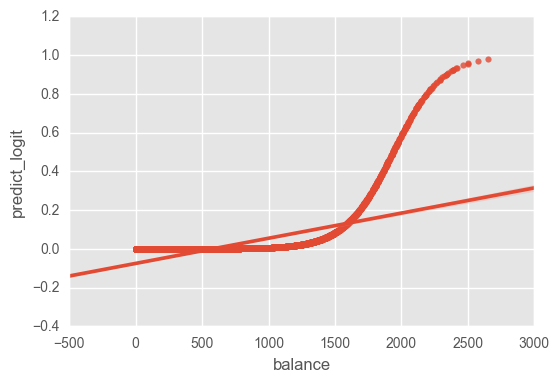

In [29]:
# Visualize the predicted probabilities across balances (bonus: add the observed values as well)
df = df.sort_values(by = 'balance')
fig, ax = 
sns.regplot(x=df['balance'], y=df['predict_logit'])

While the simplicity of the `predict()` method makes it easy to overlook the interworkings of the model. You should note that the estimates are generated by plugging values of $X$ into this equation (with your estimated Beta values):

\begin{equation*}
p(X) = \frac { { e }^{ { { B }_{ 0 } } + { B }_{ 1 }X } }{ 1+{ e }^{ { { B }_{ 0 } } + { B }_{ 1 }X}} 
\end{equation*}

# Interpreting Betas (15 minutes)

As demonstrated above, the logistic formula is **linear in logit space**. This means that changes in your variables are associated with a **change in the log odds** of your dependent variable. There are a few implications of this:

- **P-Values** retain their same interpretation (probability of observing the relationship _by chance_), and can be used to confirm/reject the null hypothesis
- **Direction** of betas (+/-) is associated with a corresponding increase/decrease in the _log odds_ of the outcome. This can be interpreted as a positive / negative relationship. 

## Units
**Units** of the betas are more difficult to interpret. Each unit increase in $X$ is _associated with_ an increase in the **log odds** of the dependent variable $Y$. As you can see in the curve above, increases in log odds are **multiplicative** in nature. This means that a unit increase in $X$ corresponds to a **different** change in $Y$ depending on your **current value of $X$** (see how the **slope** of the curve changes). However, if we **exponentiate the beta value**, we can also describe proportional increase in the **odds** (not just the increase in _log odds_). Consider the following formulas for calculating the log odds for ${X}_{i}$ and ${X}_{i - 1}$ (a unit increase in $X$):

\begin{equation*}
LogOddsX_{i} = \log \left( { \frac { p({X}_{i}) }{ 1-p({X}_{i}) } }\right) ={ { B }_{ 0 } }+{ B }_{ 1 }{X}_{i}
\end{equation*}

\begin{equation*}
LogOddsX_{i-1} = \log \left( { \frac { p({X}_{i-1}) }{ 1-p({X}_{i-1}) } }\right) ={ { B }_{ 0 } }+{ B }_{ 1 }{X}_{i-1}
\end{equation*}

Because of the **linear relationship** in logit space, we can then easily calculate the **difference** in log odds between ${X}_{i}$ and ${X}_{i + 1}$ as $B_{1}$:

\begin{equation*}
\log \left( { \frac { p({X}_{i}) }{ 1-p({X}_{i}) } }\right) - \log \left( { \frac { p({X}_{i-1}) }{ 1-p({X}_{i-1}) } }\right) = {B}_{1}
\end{equation*}

If we exponentiate each side of the equation, we can see that the **proportional increase in odds** betweeen $P(X_{i-1})$ and $P(X_{i})$ is simply ${e}^{{B}_{1}}$:

\begin{equation*}
\frac { \left( { \frac { p({ X }_{ i }) }{ 1-p({ X }_{ i }) }  } \right)  }{ \left( { \frac { p({ X }_{ i-1 }) }{ 1-p({ X }_{ i-1 }) }  } \right)  } ={ e }^{ B_{ 1} }
\end{equation*}

We can then interpret the **exponentiated beta value** as the observed **multiplicative unit increase in odds** in the dependent variable.

In the section below, you should:
- Get the `summary` of your logistic model to retrieve betas values from your model.

In [49]:
# Retrieve beta values from the model
prob = df['predict_logit']
B = []
for i in range(len(value)-1):
    px = prob[i+1]
    px1 = prob[i]
    B.append( np.log(px /(1-px))-np.log(px1/(1-px1)))
    
sns.regplot(x=B)

TypeError: regplot() takes at least 2 arguments (1 given)

Using the beta values produced by the model, describe the relationship between `balance` and `default` (make sure to note the **p-value**, **direction**, and **units** of the coefficient):

> Your insights here

# A More Interpretable Model (10 minutes)

The proportional increase of .6% in the model above is a bit small to have a good intuitive sense of. However, we can easily change our units of analysis to make this more interpretable. In the section below, you should do the following:

- Convert balance to units of \$100 and re-run the regression (hint, you'll need to create a new column or copy your dataframe)
- Extract the beta values from your model

In [39]:
# Convert balance to units of $100 and re-run the regression
B

[]

In [21]:
# Extract the beta values from you model


What is the interpretation of your beta value from your regression?

> Your insights here

# Evaluation Metrics (10 minutes)

In the section above, you've developed a strategy for interpreting the **betas** produced by your model. However, you also need to assess how well your model fits your data. In order to do this, we need to return to the purpose of our model. We want to **predict if people will default on their loans**. Before diving back into the code, we'll introduce a **confusion matrix** to represent the relationship between the data and our estimates.

## Sensitivity and Specificity
The concepts of sensitivity and specificity express how well your model accurately predicts positive and negative classes. In order to compute these, it is easy to first build a **confusion matrix** to show the total number of cases that were accurately predicted (and those that were not).

  <table>
  <tr>
    <td/>
    <td/>
    <td colspan="2"><em>Predicted Class</em></td>
    <td/>
  </tr>
  <tr>
    <td/>
    <td/>
    <td><strong>Negative (-)</strong></td>
    <td><strong>Positive (+)</strong></td>
    <td><strong>Total</strong></td>
  </tr>
  <tr>
    <td rowspan="2"><em>True Class</em></td>
    <td><strong>Negative (-)</strong></td>
    <td>True Negative (TN)</td>
    <td>False Positives (FP)</td>
    <td>Total non-cases (N)</td>
  </tr>
  <tr>
    <td><strong>Positive (+)</strong></td>
    <td>False Negatives (FN)</td>
    <td>True Positives (TP)</td>
    <td>Total cases (P)</td>
  </tr>
</table>


In the matrix above, the rows represent the **data**, while the columns represent the **predictions**. For example, the top left cell (_True Negatives_) represents the number of instances in which someone did not default, and the model predicted that they did not default. Here are the definitions of each cell:

- **True Positives**: The instances in which your model **predicts** a case (and the case **is true** in the data)
- **False Positives**: The instances in which your model **predicts** a case (and the case **is not** true in the data)
- **False Negatives**: The instances in which your model **does not** predict a case (and the case **is true** in the data)
- **True Negatives**: The instances in which your model **does not** predict a case (and the case **is not** true in the data)

Using those values, we can compute the **sensitivity** and **specificity** of our model:

\begin{equation*}
Sensitivity = \frac { True Positives }{ True Positives+False Negatives } 
\end{equation*}

\begin{equation*}
Specificity = \frac { TrueNegatives }{ TrueNegatives+FalsePositives } 
\end{equation*}

These two metrics lend important insights regarding the quality of our model:

> _**Sensitivity**_, also referred to as the _true positive rate_, tells us, of all of the **cases in the data**, how many did we accurately predict? This indicates the model's **ability to detect cases**. In other words, how **sensitively** does the model pick up on cases?

> _**Specificity**_, also referred to as the _true negative rate_, tells us, of all of the **non-cases in the data**, how many did we accurately predict? This indicates the model's ability to assign non-cases.

These metrics are directly used to calculate **Type I and Type II error rate**, which are analagous to Type I and Type II errors in statistical tests (incorrectly reject a true null hypothesis, incorrectly accept a false null hypothesis). 

> **Type I Error** rate is the proportion of instances which are **incorrectly classified as positive cases** (relative to the total number of **negative cases**). It is calculated as $1-specificity$, or simply the false positives relative to the total non-cases in the data, $FP/N$.

> **Type II Error** rate is the proportion of instances which are **incorrectly classified as negative cases** (relative to the total number of **positive cases**). It is calculated as $1-sensitivity$, or simply the false negatives relative to the total cases in the data, $FN/P$.


# Metric Calculation (15 minutes)

In this section, you'll evaluate the fit of your model by calculating the following:

- First, using a threshold of .5, use your model to predict a binary outcome (each case as 0 or 1)
- What is the **accuracy** of your model (how often does the prediction match the data)?
- What are the sensitivity, specificity, Type I error rate, and Type II error rates?

In [22]:
# First, using a threshold of .5, use your model to predict a binary outcome (each case as 0 or 1)


In [23]:
# What is the accuracy of your model (how often does the prediction match the data)?


In [24]:
# What are the sensitivity, specificity, Type I error rate, and Type II error rates?


What is your interpretation of these values?

> Your insights here

## ROC Curve (10 minutes)

It is common to compare the _true positive rate_ (sensitivity) to the _false positive rate_ (1 - specificity) at each **threshold** for classification in an [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). This [interactive visualization](http://www.navan.name/roc/) may help you better understand the relationship between thresholds and the ROC. In this section, you'll do the following:

- Generate data for the ROC curve using the `metrics.roc_curve` function
- Draw your ROC curve
- Calculate the area under your ROC curve using the `metrics.roc_auc_curve` function

In [25]:
# Generate data for the ROC curve using the `metrics.roc_curve` function


In [26]:
# Draw your ROC curve


In [27]:
# Calculate the area under your ROC curve using the metrics.roc_auc_curve function
